### Summary
<pre>
Author           : Bobby Larson
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images by retraining pretrained model
                      “InceptionV3” with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and fine-tuned model 
                      for two new label classes (Pneumonia and Normal).
                   3. With Custom Deep Convololutional Neural Network attained testing accuracy 89.53%
                      and loss 0.41.
Tools/Library    : Python, Keras, Tensorflow
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/karma0/pneumonia_classifier>Pneumonia Classifier from Chest X-Ray Images</a>
Based Upon       : <a href=https://github.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitHub)</a>
</pre>

#### Dataset
<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
</pre>

#### Instructions
1. Download the dataset from kaggle using the link above.
2. Unzip and place the `chest_xray` folder in the `data` directory.
3. Execute the `Jupyter` notebook.

## Import Libraries

In [1]:
import os
import random
import time
import datetime
import shutil
import re
import gc

from PIL import Image
import cv2

import numpy as np

from tensorflow import Tensor

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend

from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight

from mlxtend.plotting import plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Creates directory, if directory exists removes if remove parameter is set to True 
# Configure input/ output directory
def mkdir(path, remove=False):
  if remove:
    rmdir(path)
  if not os.path.exists(path):
    os.mkdir(path)
  return path


# Removes directory, if directory exists 
def rmdir(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)

        
def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    for item in dirs_files:
        item_path = directory_path+ item
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)
    # if folder empty, delete it
    files = os.listdir(path)
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
dir_file_count = lambda path: sum([len(files) for r, d, files in os.walk(path)])

### Data Visualization Function

In [3]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols
    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params


def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    plot_params["figsize"] = figsize
    plot_params["title"] = title
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    plot_params["legends"] = legends 
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    plot_params["subplot"] = None
    
    return plot_params

In [4]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    
# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])

    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)

    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)

    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [5]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = f"{image_dir}/{classes[i]}"
        subdir_files = os.listdir(subdir_path)
        subdir_file_count = len(subdir_files)
        subdir_file_mem = {}
        subdir_file_index = -1
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            image_file_paths[classes[i]].append(f"{subdir_path}/{subdir_files[subdir_file_index]}")
            
    return image_file_paths

In [6]:
name_correct = lambda name: re.sub(r'[^a-zA-Z,:]', ' ', name).title()


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs


def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()


def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [7]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        del model
    backend.clear_session()
    gc.collect()


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

### Preprocessing

In [8]:
reset_graph()
reset_callbacks()

In [9]:
datadir = "./data"

# Configure training, validation, testing directory
input_directory = f"{datadir}/chest_xray"
output_directory = mkdir(f"{datadir}/output")

training_dir = f"{input_directory}/train"
validation_dir = f"{input_directory}/val"
testing_dir = f"{input_directory}/test"

figure_directory = mkdir(f"{output_directory}/figures")
file_name_pred_batch = mkdir(f"{figure_directory}/result")
file_name_pred_sample = mkdir(f"{figure_directory}/sample")

Number of Class:  2
-------------------------------------------------------Pneumonia-------------------------------------------------------


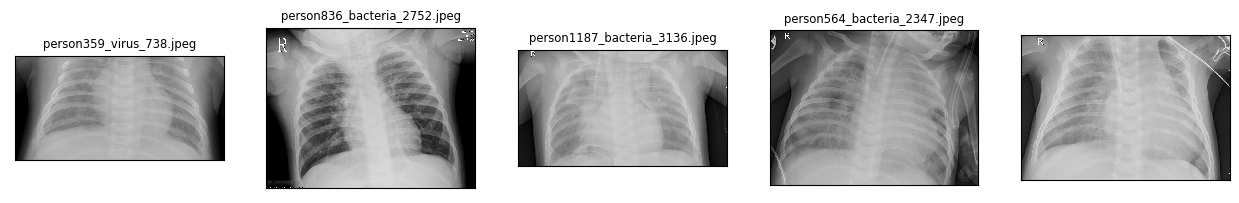


-------------------------------------------------------Normal-------------------------------------------------------


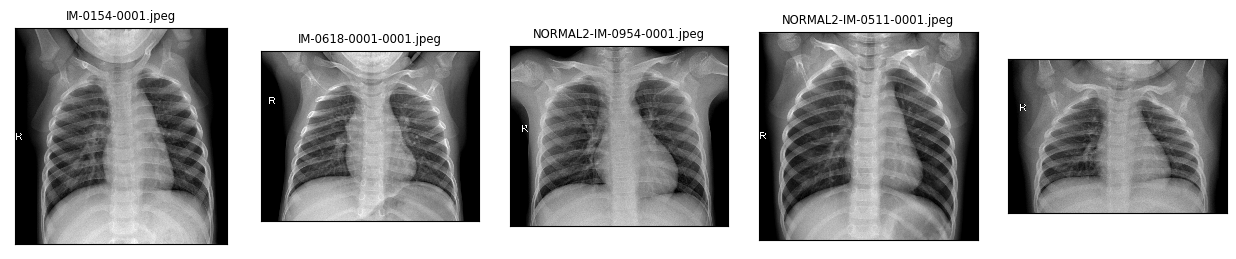


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [10]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

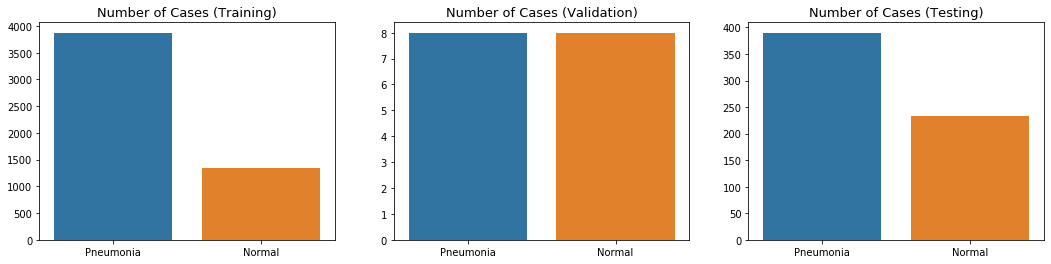

In [11]:
plot_params = get_reset_plot_params()
plot_params['figsize'] = (18,4)
plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10
plot_params['title'] = "Number of Cases"
plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]


### Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and  Dataset 

In [12]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


###  Training Files Configuration

In [13]:
cweight = \
  class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
cweight

array([1.9448173 , 0.67303226])

In [14]:
main_model_dir = mkdir(f"{output_directory}/models")
main_log_dir = mkdir(f"{output_directory}/logs")

remove_empty_folders(main_model_dir, False)
clear_directory(main_log_dir)

model_dir = mkdir(f"{main_model_dir}/{time.strftime('%Y-%m-%d_%H-%M-%S')}")
log_dir = mkdir(f"{main_log_dir}/{time.strftime('%Y-%m-%d_%H-%M-%S')}")

mkdir(model_dir, remove=True)
mkdir(log_dir, remove=True)

model_filename = f"{model_dir}/" + "{epoch:02d}-val_loss-{val_loss:.2f}-val_acc-{val_accuracy}.hdf5"
model_filename

'./data/output/models/2019-09-22_22-41-58/{epoch:02d}-val_loss-{val_loss:.2f}-val_acc-{val_accuracy}.hdf5'

### Callbacks 

In [15]:
reset_graph()
reset_callbacks()

In [16]:
callbacks = [
  ModelCheckpoint(
    model_filename,
    monitor='val_acc'
  ),

  EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
  ),

  TensorBoard(
    log_dir=log_dir,
    update_freq = 'batch'
  ),

  ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1
  ),
]

### Training/Fine-Tuning Base Model-InceptionV3 for Fine-Tuning with New Class Labels

In [17]:
# Inception V3

def build_model(nb_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    # add a global spatial average pooling layer
    x = base_model.output
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer
    predictions = Dense(nb_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(input=base_model.input, output=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
        
    return model
        
model = build_model(2)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

/home/amigx/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [18]:
print("Starting Training Model", 'Timestamp: {:%Y-%m-%d_%H:%M:%S}'.format(datetime.datetime.now()))

steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

optimizer = Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
epochs = 100

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
   train_generator,
   steps_per_epoch=steps_per_epoch,
   epochs=epochs,
   verbose=2,
   callbacks=callbacks,
   validation_data=validation_generator,
   validation_steps=validation_steps, 
   class_weight=cweight
)

print("Completed Model Training", 'Timestamp: {:%Y-%m-%d_%H:%M:%S}'.format(datetime.datetime.now()))

Starting Training Model Timestamp: 2019-09-22_22:42:02
Epoch 1/100
 - 91s - loss: 0.4580 - accuracy: 0.8704 - val_loss: 2.0743 - val_accuracy: 0.6250
Epoch 2/100
 - 88s - loss: 0.2159 - accuracy: 0.9216 - val_loss: 1.2724 - val_accuracy: 0.6875
Epoch 3/100
 - 89s - loss: 0.2213 - accuracy: 0.9181 - val_loss: 3.1372 - val_accuracy: 0.5000
Epoch 4/100
 - 92s - loss: 0.2010 - accuracy: 0.9214 - val_loss: 2.1051 - val_accuracy: 0.5625
Epoch 5/100
 - 89s - loss: 0.1928 - accuracy: 0.9243 - val_loss: 0.7695 - val_accuracy: 0.6875
Epoch 6/100
 - 89s - loss: 0.1942 - accuracy: 0.9227 - val_loss: 2.8310 - val_accuracy: 0.5000
Epoch 7/100
 - 89s - loss: 0.1855 - accuracy: 0.9281 - val_loss: 2.7081 - val_accuracy: 0.5625
Epoch 8/100
 - 89s - loss: 0.1959 - accuracy: 0.9225 - val_loss: 1.0255 - val_accuracy: 0.8125
Epoch 9/100
 - 89s - loss: 0.1972 - accuracy: 0.9218 - val_loss: 3.4852 - val_accuracy: 0.4375
Epoch 10/100
 - 89s - loss: 0.1770 - accuracy: 0.9277 - val_loss: 4.5049 - val_accuracy: 0

### Model Performance Visualization over the Epochs

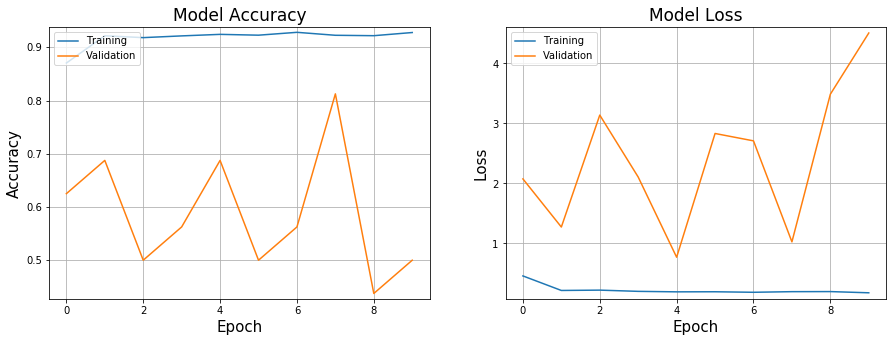

In [19]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

### Test Saved Models

In [20]:
dirs = os.listdir(main_model_dir)
[ (ix, dr) for ix, dr in enumerate(dirs) ]

[(0, '2019-09-22_20-28-00'),
 (1, '2019-09-22_22-41-58'),
 (2, '2019-09-22_20-53-20'),
 (3, '2019-09-22_19-57-20')]

In [21]:
cur_dir = f"{main_model_dir}/{dirs[-1]}"
model_names = os.listdir(cur_dir)
[ (ix, dr) for ix, dr in enumerate(model_names) ]

[(0, '04-val_loss-1.64.hdf5'),
 (1, '06-val_loss-1.97.hdf5'),
 (2, '05-val_loss-1.55.hdf5'),
 (3, '02-val_loss-0.91.hdf5'),
 (4, '03-val_loss-0.90.hdf5'),
 (5, '01-val_loss-0.70.hdf5')]

In [22]:
model_file = f"{cur_dir}/{model_names[1]}"
model_file

'./data/output/models/2019-09-22_19-57-20/06-val_loss-1.97.hdf5'

In [23]:
#model = keras.models.load_model(model_file)

In [24]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 12s 12s/step
Loss     : 0.99  
Accuracy : 70.03%


In [25]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 14s 14s/step


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 70.42%
Recall        : 89.74%
F1-Score      : 78.92%
------------------------------------------------------------------------------------------





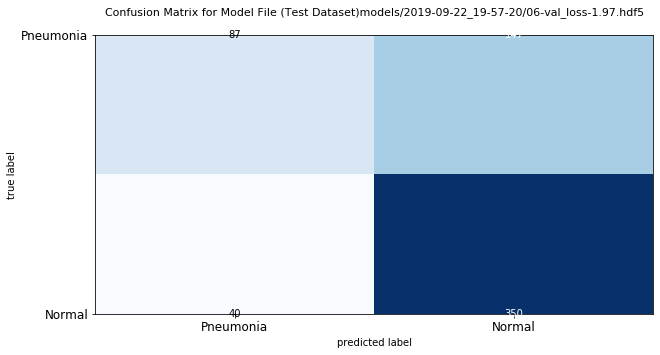




------------------------------------------------------------------------------------------
Report for Model File:  models/2019-09-22_19-57-20/06-val_loss-1.97.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

   Pneumonia       0.69      0.37      0.48       234
      Normal       0.70      0.90      0.79       390

    accuracy                           0.70       624
   macro avg       0.69      0.63      0.64       624
weighted avg       0.70      0.70      0.67       624

------------------------------------------------------------------------------------------


In [26]:
image_file_name_CM = f"{figure_directory}/CM"

title = model_file.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset)"+model_title, fontsize=11)
fig.savefig(image_file_name_CM, dpi=100)
plt.show()

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [27]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 70.03%
-----------------------------------


### Visualization

In [28]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1

        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(f"{testing_dir}"+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]

        title_text = ("%s%s%s%s%s" % ("True: ", original, "\n", "Pred: ", predicted))
        
        if original == predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')

        if plot_params["update_image"] and os.path.exists(image_file_name):
            if not os.path.isdir(image_file_name):
                os.remove(image_file_name)

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

### Visualization

In [29]:
image_file_name_batch = f"{figure_directory}/result"
image_file_name_sample = f"{figure_directory}/sample"

batch_size_t = len(y_true_batch)
class_map = {v: k for k, v in test_generator.class_indices.items()}
dpi = 100

ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

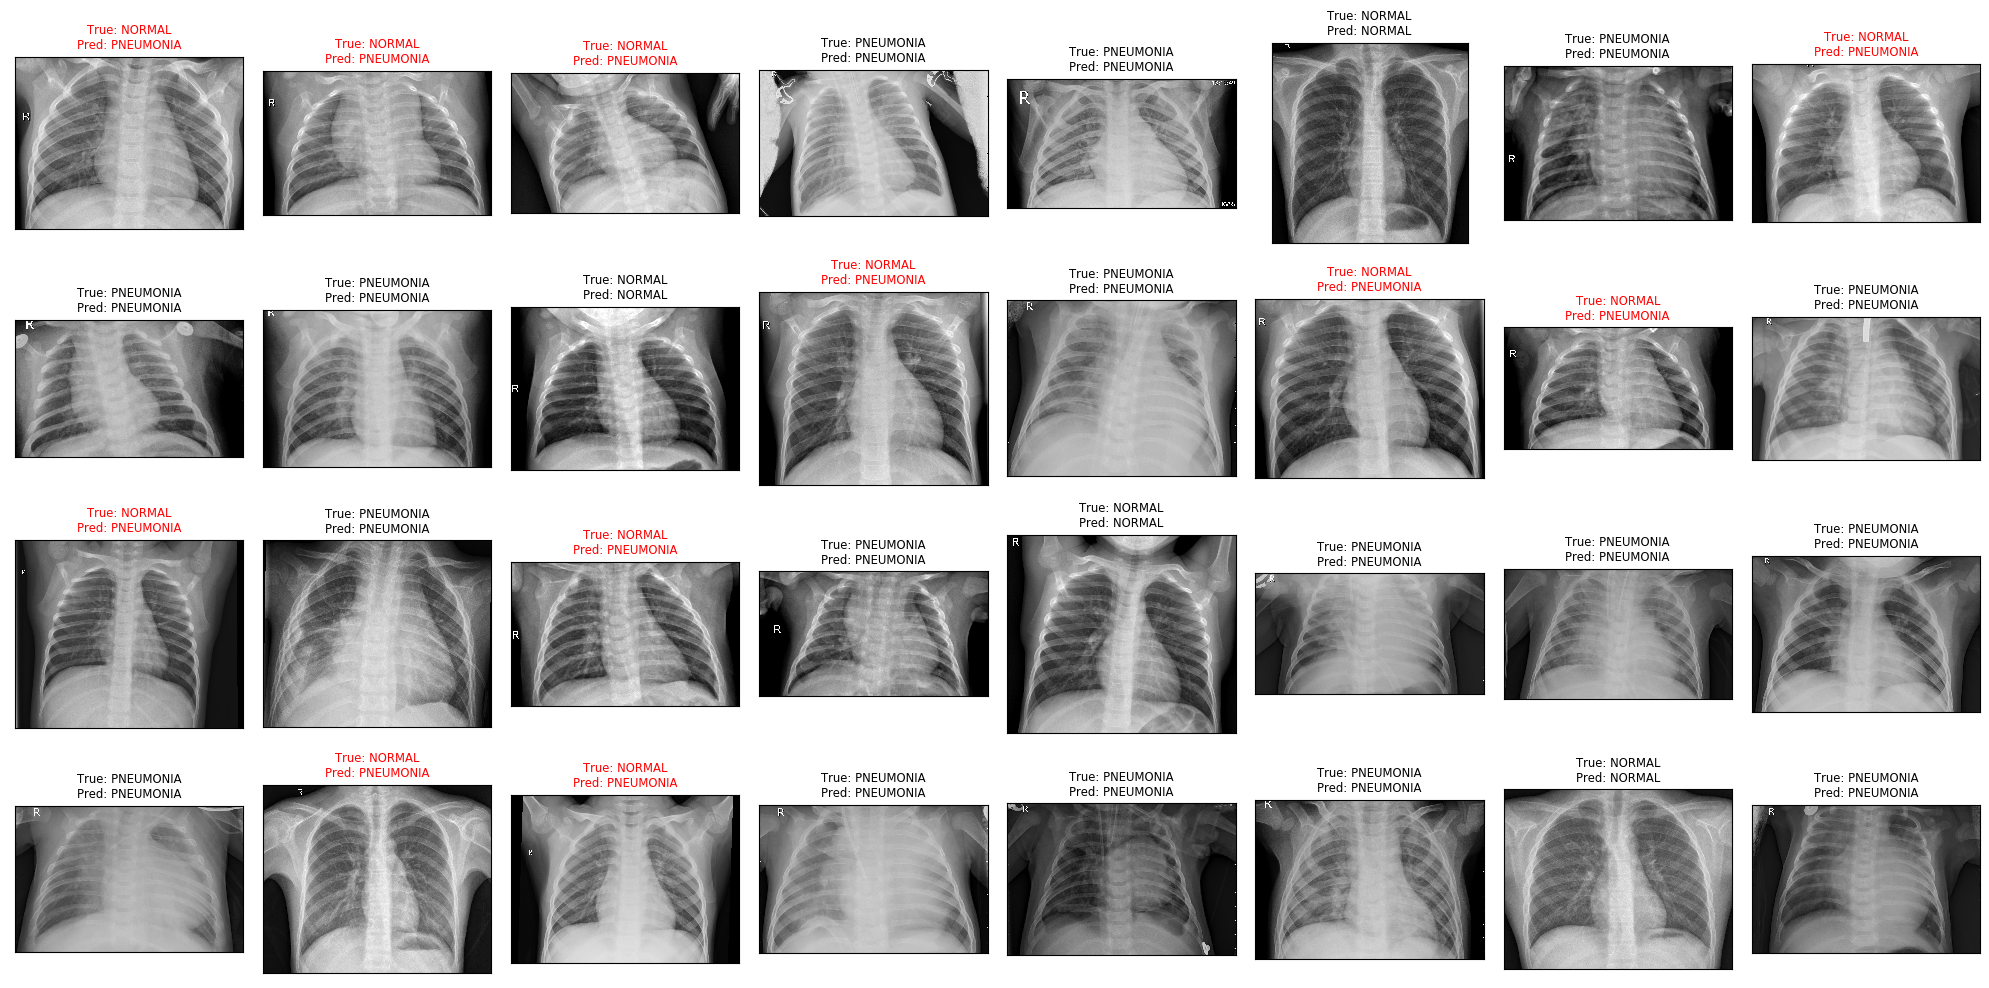

In [30]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

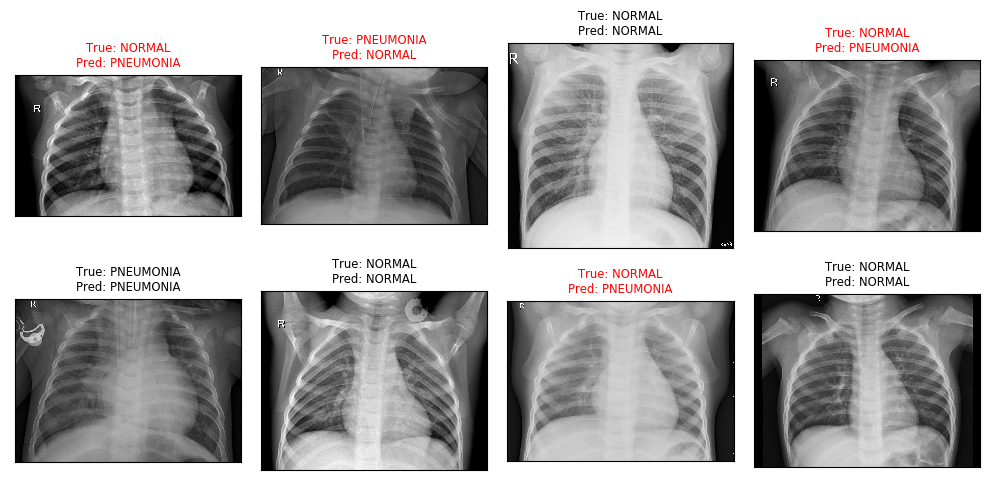

In [31]:
ncols = 4
nrows = 2

if batch_size_t < 4:
    cols = 1
    
count = ncols * nrows

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)